<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Audiowide&display=swap" rel="stylesheet">
<!-- Cyberpunk Animated Title -->
<h1 style="
    font-size: 60px;
    font-weight: bold;
    text-align:center;
    text-transform: uppercase;
    color: #0ff;
    font-family: Audiowide, sans-serif;
"> D S T - A S S I G N M E N T</h1>

<p style="
    font-size: 20px;
    color: #ff00ff;
    text-align:center;
    font-family: Audiowide, sans-serif;
">Enter the Grid.
Write the Future.</p>
<h4 style="text-align:center;font-family: Audiowide, sans-serif;">Powered By Chameleon Technologies</h4>
<style>
@keyframes neonGlow {
    from { text-shadow: 0 0 5px #0ff, 0 0 10px #0ff, 0 0 20px #0ff; }
    to { text-shadow: 0 0 10px #0ff, 0 0 20px #0ff, 0 0 40px #0ff; }
}

@keyframes neonGlowPurple {
    from { text-shadow: 0 0 5px #ff00ff, 0 0 10px #ff00ff, 0 0 20px #ff00ff; }
    to { text-shadow: 0 0 10px #ff00ff, 0 0 20px #ff00ff, 0 0 40px #ff00ff; }
}
</style>

---
All what you want deployed on Github : https://github.com/AbdoAhmedAbdelmonem/Data-Science-tools---NetworkX

---
## Course Scheduling Analysis using Graph Coloring

This notebook analyzes `course scheduling` conflicts by modeling `courses as nodes` and `student enrollments as edges` in a graph. We then use graph coloring algorithms `to find the minimum number of time periods needed to schedule courses without conflicts.`

 ---

In [10]:
import pandas as pd
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt

---

## 1. Data Loading and Preparation
<p style="
    font-family: monospace;
    color: #00ff9d;
    animation: textFlicker 5s linear infinite;
  ">
    > Load all sheets from the Excel file
  </p>

In [11]:
all_sheets = pd.read_excel("studentcoursesedit.xlsx", sheet_name=None)

df = pd.concat(all_sheets.values(), ignore_index=True)

# Rename columns to English for easier handling
df = df.rename(columns={
    "رقم الطالب": "Student ID",
    "اسم الطالب": "Student Name",
    "التخصص": "Specialization",
    "رقم المقرر": "Course Code",
    "اسم المقرر": "Course Name",
    "رمز المقرر": "Course Symbol",
    "رقم الشعبة": "Branch Number"
})

# Drop unnecessary column
df = df.drop(["م"], axis=1)
print(f"Number of unique courses: {len(df['Course Name'].drop_duplicates())}")

df

Number of unique courses: 461


,Student ID,Student Name,Specialization,Course Code,Course Name,Course Symbol,Branch Number
0,1105312002,عبدالمجيد علي عبدالرحمن الشاوي,السجلات الطبية-2,110501,المهارات اللغوية,ARAB 101,211637
1,1105311013,سالم سليمان دهش الشمري,السجلات الطبية-2,110501,المهارات اللغوية,ARAB 101,211637
2,1105312004,احمد عبدالله صالح الحربي,السجلات الطبية-2,110511,التحرير العربي,ARAB 102,111647
3,1105321021,يوسف عبدالله سليمان المهوس,السجلات الطبية-2,110511,التحرير العربي,ARAB 102,211647
4,1105312011,سطام بندر جايز المطيري,السجلات الطبية-2,110511,التحرير العربي,ARAB 102,211647
...,...,...,...,...,...,...,...
11098,1501311010,أحمد عبدالعزيز محمد العبيدان,هندسة الحاسب,150147,هندسة البرمجيات,342عال,215153
11099,1401321075,صالح محمد صالح الرميح,علوم الحاسب,150147,هندسة البرمجيات,342عال,115152
11100,1502301005,يزيد محمد صالح الهجرس,علوم حاسب-1,150147,هندسة البرمجيات,342عال,115155
11101,1502312010,محمد عبدالله محيميد العريني,علوم الحاسب,150147,هندسة البرمجيات,342عال,115152


---
## 2. Data Processing


In [12]:
df_unique = df[["Course Symbol", "Course Name"]].drop_duplicates()
df_unique = df_unique.set_index("Course Symbol")

# Count students per course
df_grouped_by_Symbol = df[["Student Name", "Course Symbol"]].set_index("Course Symbol")
df_grouped_by_Symbol = df_grouped_by_Symbol.groupby("Course Symbol").count()
df_joint = df_unique.join(df_grouped_by_Symbol, on="Course Symbol")

# Rename columns for clarity
df_part1 = df_joint.rename(columns={"Student Name": "Number of Students"})
df_part1

,Course Name,Number of Students
Course Symbol,,
ARAB 101,المهارات اللغوية,6
ARAB 102,التحرير العربي,4
BIOL 101,Biology,1
ISLM 103,النظام الإقتصادي في الإسلام,1
ENGL 102,English Language 2,3
...,...,...
493عال,مواضيع مختارة في علوم الحاسب,1
عال 339,نظرية الحوسبة,2
227عال,نظم التشغيل,7


---
## 3. Graph Construction

In [13]:
student_course_pairs = [(row['Student Name'], row['Course Symbol']) for index, row in df.iterrows()]

# Create dictionary of students and their courses
final_dict = {}
for student, course in student_course_pairs:
    if student not in final_dict:
        final_dict[student] = []
    final_dict[student].append(course)

# Build the graph
Graph = nx.Graph()

# Generate all possible course pairs that share students
generated_pairs = []
for courses in final_dict.values():
    generated_pairs.extend(combinations(courses, 2))

# Add edges to the graph
Graph.add_edges_from(generated_pairs)

# Print graph statistics
print("Number of Edges:", Graph.number_of_edges())
print("Number of Nodes:", Graph.number_of_nodes())

Number of Edges: 5311
Number of Nodes: 479


---
## 4. Graph Coloring Analysis

<p style="
    font-family: monospace;
    color: #00ff9d;
    animation: textFlicker 5s linear infinite;
  ">
    > Graph Coloring Comparison...
  </p>

In [14]:
def analyze_coloring(strategy_name, coloring_func):
    """Helper function to analyze each coloring strategy"""
    coloring = coloring_func(Graph)
    df = pd.DataFrame(list(coloring.items()), columns=["Course Symbol", "Period"])
    df = df.astype({"Course Symbol": str, "Period": int})

    max_period = df["Period"].max()
    max_courses = df[df["Period"] == max_period]

    print(f"\n{strategy_name} Results:")
    print(f"Number of periods needed: {max_period + 1}")
    print(f"Courses in final period ({max_period}):")
    print(max_courses.to_string(index=False))

    return df

---
## Analyze all three strategies

In [15]:
strategies = [
    ("Connected Sequential BFS", lambda G: nx.coloring.greedy_color(G, strategy="connected_sequential_bfs")),
    ("Largest First", lambda G: nx.coloring.greedy_color(G, strategy="largest_first")),
    ("Connected Sequential DFS", lambda G: nx.coloring.greedy_color(G, strategy="connected_sequential_dfs"))
]

results = {}
for name, func in strategies:
    results[name] = analyze_coloring(name, func)

comparison = pd.DataFrame({
    'Strategy': [name for name, _ in strategies],
    'Periods Needed': [results[name]['Period'].max() + 1 for name in results],
    'Courses in Final Period': [len(results[name][results[name]['Period'] == results[name]['Period'].max()])
                              for name in results]
})


Connected Sequential BFS Results:
Number of periods needed: 22
Courses in final period (21):
Course Symbol  Period
      224 دوي      21

Largest First Results:
Number of periods needed: 21
Courses in final period (20):
Course Symbol  Period
      420 صكل      20

Connected Sequential DFS Results:
Number of periods needed: 22
Courses in final period (21):
Course Symbol  Period
      418 دوي      21


---
## 5. Final Output Preparation

In [16]:
df_unique = df[["Course Symbol", "Course Name"]].drop_duplicates().set_index("Course Symbol")
df_student_count = df[["Student Name", "Course Symbol"]].groupby("Course Symbol").count().rename(
    columns={"Student Name": "Number of Students"})

final_output = results["Largest First"].set_index("Course Symbol")
final_output = final_output.join(df_unique).join(df_student_count).sort_values("Period")
final_output.to_excel("combined_course_scheduling.xlsx")

print("\nFinal schedule saved to 'combined_course_scheduling.xlsx'")


Final schedule saved to 'combined_course_scheduling.xlsx'


---
## 6. Visualization

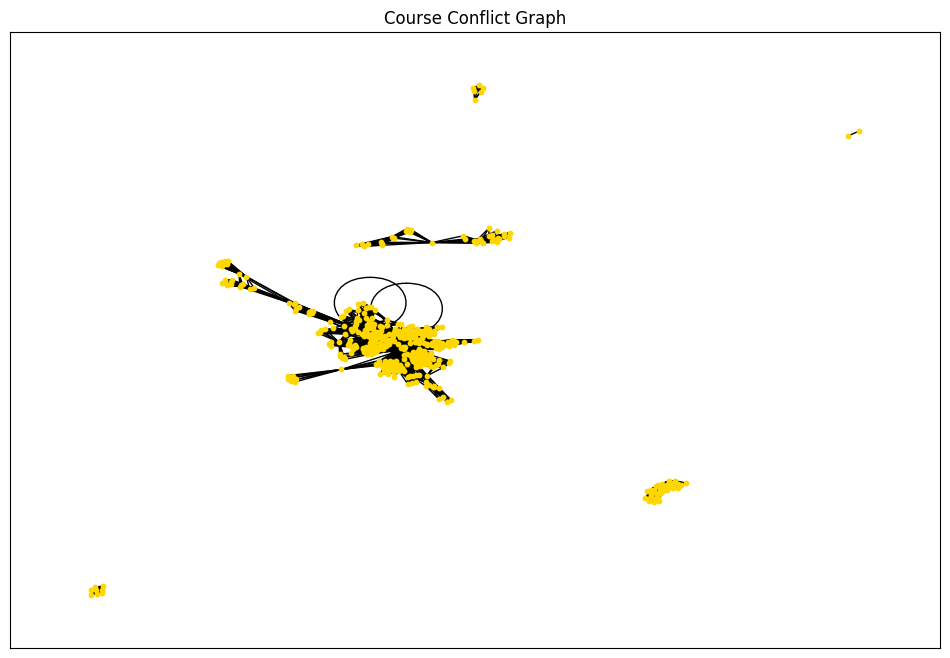

In [17]:
pos = nx.spring_layout(Graph)
plt.figure(figsize=(12, 8))
nx.draw_networkx(Graph, pos, with_labels=False, node_color="gold", node_size=10)
plt.title("Course Conflict Graph")
plt.show()

---
## `Abdelrahman Ahmed Abdelmonem `
### `23011311`
---